- TensorFlowでのSoftmax回帰の実装・可視化・識別器の騙し方
    - http://roomba.hatenablog.com/entry/2017/04/21/154954

In [39]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import tensorflow as tf  # version 1.8.0
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [40]:
data_Path = Path(os.getcwd()).parent / "data"

In [41]:
mnist = input_data.read_data_sets(str(data_Path / "MNIST_data"), one_hot=True)

Extracting /Users/sugisaki/workdir/git/bitbucket/learning_machine_learnig/visualize_deep_learning_weights/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/sugisaki/workdir/git/bitbucket/learning_machine_learnig/visualize_deep_learning_weights/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/sugisaki/workdir/git/bitbucket/learning_machine_learnig/visualize_deep_learning_weights/data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/sugisaki/workdir/git/bitbucket/learning_machine_learnig/visualize_deep_learning_weights/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [42]:
mnist.train.images.shape

(55000, 784)

# Show mnist data

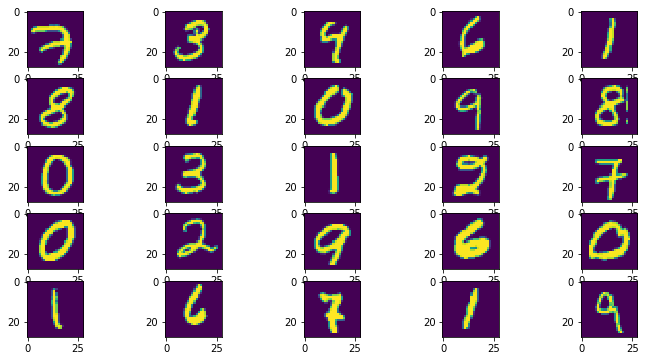

In [43]:
fig = plt.figure(figsize=(12,6))

for i, img in enumerate(mnist.train.images[:25]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.reshape(28, 28),
              interpolation="none",
             )

# Softmax Regression の実装

In [56]:
# ログ用のディレクトリ用意
LOG_DIR = Path(os.getcwd()) / "log"

if os.path.exists(str(LOG_DIR)):
    shutil.rmtree(str(LOG_DIR))
os.mkdir(str(LOG_DIR))

In [45]:
# TenforBoard用の準備
def variable_summaries(var):
    """ テンソルに様々なsummaryを付加する（TensorBoardでの可視化に利用）
    Args:
        var: summaryを付加したいテンソル
    Returns:
        なし（summary opの付加を行うだけの関数）
    """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Computational Graph (計算グラフ) 構築

In [46]:
with tf.name_scope("input"):
    # 入力定義
    # placeholder
    x = tf.placeholder(tf.float32, [None, 784], name="image")  # input image
    y_ = tf.placeholder(tf.float32, [None, 10], name="label")  # label

with tf.name_scope("variable"):
    # 学習可能なパラメータ
    # Variables
    with tf.name_scope("Weight"):
        W = tf.Variable(tf.zeros([784, 10]))  # Affine Layer 1 の重み
        variable_summaries(W)
    with tf.name_scope("Bias"):
        b = tf.Variable(tf.zeros([10]))       # Affine Layer 1 の重み（バイアス）
        variable_summaries(b)

In [47]:
# inference (推論)
def inference(images, weights, biases):
    """
    Parameters
    ----------
    images : tf.placeholder
        image placeholder
    weights : tf.Variable
        weight Variable
    biases : tf.Variable
        biases Variable

    Returns
    -------
    logits : 
        計算されたlogit
    """
    with tf.name_scope("logits"):
        logits = tf.matmul(a=images, b=weights) + biases  # Affine Layer 1 の出力
                                                          # 728個の入力に異なる重みをかけた和を
                                                          # それぞれ10個の出力
        tf.summary.histogram("logits_histgram", logits)

    return logits

In [48]:
def loss(logits, labels):
    """
    Parameters
    ----------
    logits : 
        シグモイド
    labels : 
        answer labels

    Returns
    -------
    cross_entropy : cross_entropy
    """
    with tf.name_scope("loss"):
        # Affine Layer 1 の出力をsoftmax関数を通すことで確率のような形で出力
        # softmaxの出力から交差エントロピーを求める.
        cross_entropy = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=labels,
                                                                                            logits=logits),
                                       name="cross_entropy_mean",
                                      )
        tf.summary.scalar("cross_entropy", cross_entropy)  # logging
    return cross_entropy

In [49]:
def train(loss, learning_rate):
    """
    Parameters
    ----------
    loss : 
        誤差
    learning_rate : 
        学習率

    Returns
    -------
    train_op :
        学習
    """
    with tf.name_scope("train"):
        # 与えた学習率に従った勾配降下法
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        # lossの最小化
        train_op = optimizer.minimize(loss)
    return train_op

In [50]:
def evaluate(logits, labels):
    """
    Returns
    -------
    accuracy :
        識別精度
    """
    with tf.name_scope("evaluation"):
        # 予測と正解の比較
        correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        # 識別精度の算出
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32),  # bool --> float32 (True->1., False->0.)
                                  name="accuracy",
                                 )
        tf.summary.scalar("accuracy", accuracy)  # logging
    return accuracy

In [51]:
# Graph
logits = inference(x, W, b)
loss = loss(logits=logits, labels=y_)
train_op = train(loss=loss, learning_rate=0.1)
accuracy =  evaluate(logits=logits, labels=y_)
summary = tf.summary.merge_all()  # すべてのsummryの統合

## Excute Computational Graph

In [53]:
sess =  tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [57]:
# summaryをファイルに出力するためのwriter
train_writer = tf.summary.FileWriter(str(LOG_DIR / "train"), sess.graph)
test_writer = tf.summary.FileWriter(str(LOG_DIR / "test"))

In [60]:
MAX_STEP = 2000
BATCH_SIZE = 100
for step in range(MAX_STEP):
    batch_xs , batch_ys = mnist.train.next_batch(BATCH_SIZE)
    # train
    sess.run(fetches=train_op,
             feed_dict={
                 x: batch_xs,
                 y_: batch_ys
             }
            )
    # 100 step ごとに結果表示
    if step % 100 == 0:
        test_loss, test_accuracy = sess.run(fetches=[loss, accuracy],
                                            feed_dict={
                                                x: mnist.test.images,
                                                y_: mnist.test.labels
                                            }
                                           )
        print("step: {}, test_accuracy: {}, test_loss: {}".format(step, test_accuracy, test_loss))
        # logging
        train_summary_str = sess.run(fetches=summary,
                                     feed_dict={
                                         x: batch_xs,
                                         y_: batch_ys
                                     }
                                    )
        test_summary_str = sess.run(fetches=summary,
                                    feed_dict={
                                        x: mnist.test.images,
                                        y_: mnist.test.labels
                                    }
                                   )
        train_writer.add_summary(summary=train_summary_str, global_step=step)
        test_writer.add_summary(summary=test_summary_str, global_step=step)
train_writer.close()
test_writer.close()

step: 0, test_accuracy: 0.37070000171661377, test_loss: 2.113624095916748
step: 100, test_accuracy: 0.864300012588501, test_loss: 0.5846129655838013
step: 200, test_accuracy: 0.8847000002861023, test_loss: 0.4668223559856415
step: 300, test_accuracy: 0.8928999900817871, test_loss: 0.4173779785633087
step: 400, test_accuracy: 0.8973000049591064, test_loss: 0.3916003406047821
step: 500, test_accuracy: 0.9003999829292297, test_loss: 0.37451133131980896
step: 600, test_accuracy: 0.9035999774932861, test_loss: 0.3620113730430603
step: 700, test_accuracy: 0.9050999879837036, test_loss: 0.35336539149284363
step: 800, test_accuracy: 0.9078999757766724, test_loss: 0.34370186924934387
step: 900, test_accuracy: 0.9072999954223633, test_loss: 0.33609920740127563
step: 1000, test_accuracy: 0.9090999960899353, test_loss: 0.33115458488464355
step: 1100, test_accuracy: 0.9082000255584717, test_loss: 0.3291558027267456
step: 1200, test_accuracy: 0.9121000170707703, test_loss: 0.3239915668964386
step: 1

# TensorBoard

# Visualize Weights

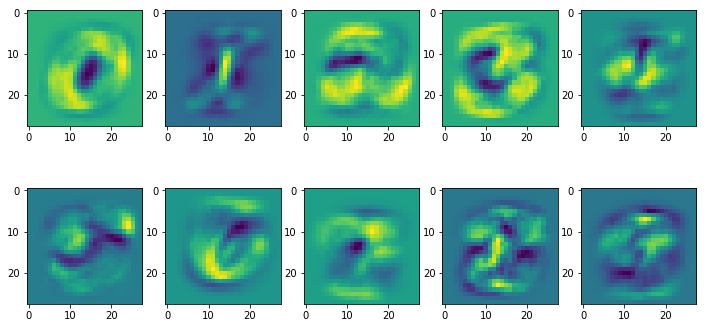

In [67]:
fig = plt.figure(figsize=(12, 6))
for i in range(W.eval().shape[1]):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(W.eval()[:, i].reshape(28, 28), interpolation="none")

In [63]:
W.eval()

(784, 10)

In [70]:
sum(W.eval()[:, 2])

8.48824963771061